In [1]:
%matplotlib inline

In [2]:
import os
import sys
import git
import pathlib

import random

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # use GPU
# Using GPU during inference has deterministic results (same as CPU)

PROJ_ROOT_PATH = pathlib.Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
PROJ_ROOT =  str(PROJ_ROOT_PATH)
if PROJ_ROOT not in sys.path:
    sys.path.append(PROJ_ROOT)

from libs import utils, mnist32_cnn
from libs.constants import model_seeds
from libs.errmatmul import matmul_ERR, N_THREADS_PER_BLOCK
from libs.fitnessfns import NO_OF_CLASSES

In [3]:
# Limit GPU growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
# Prepare dataset
# Combine test and train images together into one dataset
DATASET_PATH = str(pathlib.Path(PROJ_ROOT_PATH / "datasets" / "mnist.npz" ))
(train_images, train_labels), (test_images, test_labels) = mnist.load_data(path=DATASET_PATH)
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0  

all_images =np.concatenate([train_images, test_images], axis=0)
all_labels =np.concatenate([train_labels, test_labels], axis=0)
all_images = np.expand_dims(all_images, axis=-1)

# resize the input shape , i.e. old shape: 28, new shape: 32
image_x_size = 32
image_y_size = 32
all_images = tf.image.resize(all_images, [image_x_size, image_y_size]) 

In [5]:
model_type = "mnist32-cnn_1024_256_64"
model_seed = model_seeds[0]

In [6]:
# Get model
model_instance = model_type + "-" + str(model_seed)
dataset, model_arch, model_config, layer_widths, seed = utils.instancename2metadata(model_instance)
model_meta_type, model_type, model_instance = utils.metadata2instancenames(dataset, model_arch, layer_widths, seed)

model_folder = pathlib.Path(PROJ_ROOT_PATH / "models" / model_type)
model_filename = model_instance + ".h5"
model_file = pathlib.Path(model_folder/ model_filename)

In [7]:
no_im = 1024 # no of images per batch
images = all_images[0:no_im]
# image = tf.expand_dims(all_images[0],axis=0)

In [9]:
dummy_error_profile = np.zeros((20_000,32), dtype="float32")

In [10]:
# Load model
model = tf.keras.models.load_model(model_file)
# model.summary()

In [11]:
# get weights and biases from model
conv2d_kernels, conv2d_biases = model.get_layer("c0").weights
fc_0_weights, fc_0_biases = model.get_layer("h0").weights
fc_1_weights, fc_1_biases = model.get_layer("h1").weights
fc_2_weights, fc_2_biases = model.get_layer("h2").weights
op_layer_weights, op_layer_biases = model.get_layer("op").weights

In [12]:
# conv2d_kernels.shape, conv2d_biases.shape
# fc_0_weights.shape, fc_0_biases.shape
# fc_1_weights.shape, fc_1_biases.shape
# fc_2_weights.shape, fc_2_biases.shape
# op_layer_weights.shape, op_layer_biases.shape

In [13]:
c0_out_list= []
pool_out_list= []
flat_out_list= []
fc_0_out_list= []
fc_1_out_list= []
fc_2_out_list= []
op_layer_out_list= []

In [14]:
# convolution layer
## get dimension constants
kr_ht, kr_wt, no_ch, no_kr = conv2d_kernels.shape

assert no_im == images.shape[0]
im_ht = images.shape[1]
im_wt = images.shape[2]
assert no_ch == images.shape[-1]

y_ht = im_ht - kr_ht + 1
y_wt = im_wt - kr_wt + 1

no_of_patches = y_ht * y_wt
patch_len     = kr_ht * kr_wt * no_ch

In [15]:
## extract images patches
patches = tf.image.extract_patches(images=images,
                                 sizes=[1, kr_ht, kr_wt, 1],
                                 strides=[1, 1, 1, 1],
                                 rates=[1, 1, 1, 1],
                                 padding='VALID')
## flatten patches
flat_patches = tf.reshape(patches, (no_im, no_of_patches, patch_len))
## tranpose for matrix multiplication
flat_patches = tf.transpose(flat_patches, (0,2,1))

## flatten filter kernels
### first reorder kernels by no. of output-kernels
flat_kernels = tf.transpose(conv2d_kernels, perm=(3,0,1,2))
flat_kernels = tf.reshape(flat_kernels, (no_kr, kr_ht*kr_wt*no_ch))
# flat_kernels = tf.broadcast_to(flat_kernels, (no_im, no_kr, kr_ht*kr_wt*no_ch))

In [16]:
## perform matrix multiplication
# conv_out = tf.matmul(flat_kernels, flat_patches)
conv_out_list = []
for im in range(no_im):
    single_im_patch = flat_patches[im,:,:]
    # conv_out_list.append(tf.matmul(flat_kernels, single_im_patch))
    BLOCK_HEIGHT = N_THREADS_PER_BLOCK # no. of threads per block
    BLOCK_WIDTH = kr_ht*kr_wt # totcols is always (going to be) a multiple of BLOCK_WIDTH
    BATCH_BLOCK_SIZE = 32 # user-defined: NOT the actual batch block size in this context.
                            # simply the tile block width of matB
    # pad matrix for good matrix shape
    no_cols_to_pad = BATCH_BLOCK_SIZE-(single_im_patch.shape[1]%BATCH_BLOCK_SIZE)
    paddings = tf.constant([[0, 0,], # padding above and below
                            [0, no_cols_to_pad]]) # padding left and right
    padded_single_im_patch = tf.pad(single_im_patch, 
                                    paddings,
                                    mode="CONSTANT", 
                                    constant_values=0.0)
    conv_out_list.append(matmul_ERR(flat_kernels, 
                                               padded_single_im_patch,
                                               BLOCK_HEIGHT, 
                                               BLOCK_WIDTH, 
                                               BATCH_BLOCK_SIZE, 
                                               ERR_PROFILE=dummy_error_profile,
                                               ERR_PARAM_TF=None,)[:,:-no_cols_to_pad])
conv_out = tf.stack(conv_out_list)
conv_out = tf.transpose(conv_out, (0,2,1))
conv_out = tf.reshape(conv_out, (no_im, y_ht,y_wt, no_kr))
c0_out_list.append(conv_out.numpy())

## Add bias
conv_out = tf.nn.bias_add(conv_out, conv2d_biases)
## ReLU
conv_out = tf.nn.relu(conv_out)

In [17]:
# # Sanity Check AGAIN
# tf.reduce_sum(conv_out - model.layers[0](images))

# Sanity check for convolutional layer
# tf_conv_out = tf.nn.conv2d(input=images,
#                             filters=conv2d_kernels,
#                             strides=[1,1,1,1],
#                             padding="VALID",
#                             data_format='NHWC',
#                             dilations=None,
#                             name=None
#                         )

# # convolutional layer sanity check
# tf_conv_layer_dummy = tf.keras.layers.Conv2D(32, (4, 4), 
#                                   activation='relu', 
#                                   input_shape=(32, 32, 1))
# # get layer running
# dummy_input = tf.random.normal((1,32,32,1))
# tf_conv_layer_dummy(dummy_input);

# # load the weights
# tf_conv_layer_dummy.set_weights([conv2d_kernels, conv2d_biases])
# # run the convolution, bias adding and relu
# tf_conv_layer_out = tf_conv_layer_dummy(images);
# # check if outputs match
# tf.reduce_sum(conv_out-tf_conv_layer_out)

In [18]:
# Apply Max Pooling
pool_out = tf.nn.max_pool(
                        conv_out,
                        ksize=[1, 2, 2, 1], #(batch_size, height, width, depth)
                        strides=[1, 2, 2, 1], #(batch_size, height, width, depth)
                        padding='VALID')
# pool_out.shape

In [19]:
# # Sanity Check for pooling layer
# tf.reduce_sum(pool_out - model.layers[1](model.layers[0](images)))

In [20]:
# Flatten
flat_out = tf.reshape(pool_out, (no_im, -1) ) #[batch_size, flat_vec_size]
# flat_out.shape
# # Tranpose for multiplication
# flat_out = tf.transpose(flat_out, perm=[1,0])

In [21]:
# # Sanity Check for flatten layer
# tf.reduce_sum(flat_out - model.layers[2](model.layers[1](model.layers[0](images))))

In [38]:
flat_out.shape

TensorShape([1024, 6272])

In [22]:
# # Sanity Check for flatten layer
# flayer = tf.keras.layers.Flatten()
# flayer(pool_out)

In [23]:
# tranpose input vector
fc_0_in = tf.transpose(flat_out, perm=[1,0]) #[flat_vec_size, batch_size]
# fc_0_in.shape

# transpose weight matrices
fc_0_weights_tr = tf.transpose(fc_0_weights, perm=[1,0]) #[no_of_weights, flat_vec_size]
# fc_0_weights_tr.shape

# Multiply input with weights
# fc_0_mult_out = tf.linalg.matmul(fc_0_weights_tr, fc_0_in)
BLOCK_HEIGHT = N_THREADS_PER_BLOCK # no. of threads per block
BLOCK_WIDTH = 32 # totcols is always (going to be) a multiple of BLOCK_WIDTH
BATCH_BLOCK_SIZE = 1 # user-defined: assuming batchsize is always a multiple of BATCH_BLOCK_SIZE
fc_0_mult_out = matmul_ERR(fc_0_weights_tr, 
                                       fc_0_in,
                                       BLOCK_HEIGHT, 
                                       BLOCK_WIDTH, 
                                       BATCH_BLOCK_SIZE, 
                                       ERR_PROFILE=dummy_error_profile,
                                       ERR_PARAM_TF=None,)
fc_0_out_list.append(fc_0_mult_out.numpy())
# Add bias
fc_0_bout = tf.add(fc_0_mult_out, tf.expand_dims(fc_0_biases,axis=1))
# RelU
fc_0_out = tf.nn.relu(fc_0_bout)
# fc_0_out needs to be transposed again in fc_1_in
# so although fc_0_out shape is not "standard", we output it as it is
# fc_0_out = tf.transpose(fc_0_out, perm=[1,0]) #[batch_no, vector]

In [24]:
# # Sanity Check for fc_0_out
# tf.reduce_max( tf.abs(tf.transpose(fc_0_out, perm=[1,0]) - model.layers[3](model.layers[2](model.layers[1](model.layers[0](images))))))

In [25]:
# We don't tranpose fc_0_out to convert to fc_1_in
# fc_1_in = tf.transpose(flat_out, perm=[1,0])
fc_1_in = fc_0_out
fc_1_weights_tr = tf.transpose(fc_1_weights, perm=[1,0])

# fc_1_mult_out = tf.linalg.matmul(fc_1_weights_tr, fc_1_in)
BLOCK_HEIGHT = N_THREADS_PER_BLOCK # no. of threads per block
BLOCK_WIDTH = 32 # totcols is always (going to be) a multiple of BLOCK_WIDTH
BATCH_BLOCK_SIZE = 1 # user-defined: assuming batchsize is always a multiple of BATCH_BLOCK_SIZE
fc_1_mult_out = matmul_ERR(fc_1_weights_tr, 
                                       fc_1_in,
                                       BLOCK_HEIGHT, 
                                       BLOCK_WIDTH, 
                                       BATCH_BLOCK_SIZE, 
                                       ERR_PROFILE=None,
                                       ERR_PARAM_TF=None,)
fc_1_out_list.append(fc_1_mult_out.numpy())

fc_1_bout = tf.add(fc_1_mult_out, tf.expand_dims(fc_1_biases,axis=1))
fc_1_out = tf.nn.relu(fc_1_bout)
# fc_1_out needs to be transposed again in fc_2_in
# so although fc_1_out shape is not "standard", we output it as it is
# fc_1_out = tf.transpose(fc_1_out, perm=[1,0])

In [26]:
# # Sanity Check for fc_1_out
# tf.reduce_max( tf.abs(tf.transpose(fc_1_out, perm=[1,0]) - 
#                       model.layers[4](
#                           model.layers[3](
#                               model.layers[2](
#                                   model.layers[1](
#                                       model.layers[0](images)))))))

In [27]:
# We don't tranpose fc_1_out to convert to fc_2_in
# fc_2_in = tf.transpose(fc_1_out, perm=[1,0])
fc_2_in = fc_1_out
fc_2_weights_tr = tf.transpose(fc_2_weights, perm=[1,0])

# fc_2_mult_out = tf.linalg.matmul(fc_2_weights_tr, fc_2_in)
BLOCK_HEIGHT = N_THREADS_PER_BLOCK # no. of threads per block
BLOCK_WIDTH = 32 # totcols is always (going to be) a multiple of BLOCK_WIDTH
BATCH_BLOCK_SIZE = 1 # user-defined: assuming batchsize is always a multiple of BATCH_BLOCK_SIZE
fc_2_mult_out = matmul_ERR(fc_2_weights_tr, 
                                       fc_2_in,
                                       BLOCK_HEIGHT, 
                                       BLOCK_WIDTH, 
                                       BATCH_BLOCK_SIZE, 
                                       ERR_PROFILE=None,
                                       ERR_PARAM_TF=None,)
fc_2_out_list.append(fc_2_mult_out.numpy())

fc_2_bout = tf.add(fc_2_mult_out, tf.expand_dims(fc_2_biases,axis=1))
fc_2_out = tf.nn.relu(fc_2_bout)
# fc_2_out needs to be transposed again in op_layer_in
# so although fc_2_out shape is not "standard", we output it as it is
# fc_2_out = tf.transpose(fc_2_out, perm=[1,0])

In [28]:
# # Sanity Check for fc_2_out
# tf.reduce_max( tf.abs(tf.transpose(fc_2_out, perm=[1,0]) - 
#                       model.layers[5](
#                           model.layers[4](
#                               model.layers[3](
#                                   model.layers[2](
#                                       model.layers[1](
#                                           model.layers[0](images))))))))

In [29]:
# We don't tranpose fc_2_out to convert to op_layer_in
# fc_2_in = tf.transpose(fc_1_out, perm=[1,0])
op_layer_in = fc_2_out
op_layer_weights_tr = tf.transpose(op_layer_weights, perm=[1,0])

# op_layer_mult_out = tf.linalg.matmul(op_layer_weights_tr, op_layer_in)
BLOCK_HEIGHT = NO_OF_CLASSES # no. of threads per block
BLOCK_WIDTH = 32 # totcols is always (going to be) a multiple of BLOCK_WIDTH
BATCH_BLOCK_SIZE = 1 # user-defined: assuming batchsize is always a multiple of BATCH_BLOCK_SIZE
op_layer_mult_out = matmul_ERR(op_layer_weights_tr, 
                                       op_layer_in,
                                       BLOCK_HEIGHT, 
                                       BLOCK_WIDTH, 
                                       BATCH_BLOCK_SIZE, 
                                       ERR_PROFILE=None,
                                       ERR_PARAM_TF=None,)
op_layer_out_list.append(op_layer_mult_out.numpy())

op_layer_bout = tf.add(op_layer_mult_out, tf.expand_dims(op_layer_biases,axis=1))
op_layer_out = tf.nn.softmax(op_layer_bout, axis=0)
op_layer_out = tf.transpose(op_layer_out, perm=[1,0])

In [30]:
all_conv_out = np.array(c0_out_list).flatten()
all_pool_out = np.array(pool_out_list).flatten()
all_flat_out = np.array(flat_out_list).flatten()
all_fc_0_out = np.array(fc_0_out_list).flatten()
all_fc_1_out = np.array(fc_1_out_list).flatten()
all_fc_2_out = np.array(fc_2_out_list).flatten()
all_op_layer_out = np.array(op_layer_out_list).flatten()

In [31]:
data = [
        all_conv_out,
        # all_pool_out,
        # all_flat_out,
        all_fc_0_out,
        all_fc_1_out,
        all_fc_2_out,
        all_op_layer_out,
       ]

In [32]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
cm = plt.get_cmap('tab20')
color_list = [cm(i*2-1) for i in range(cm.N)]

cmdark_list = [cm(i*2+1) for i in range(cm.N)]

Text(0.5, 0.98, 'Range of Activation Values for mnist32-cnn')

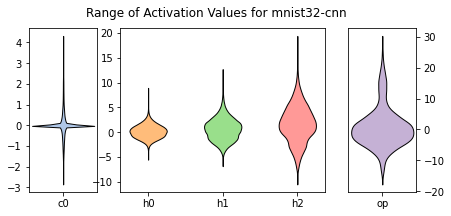

In [36]:
# Plot figure
fig_width = 3.125/0.9 * 2
fig_height = fig_width / 1.618 *0.7

# fig, axs = plt.subplots(nrows=1,
#                         ncols=3,
#                         figsize=[fig_width,fig_height], # in inches
#                         sharex=False)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.05)

fig = plt.figure(figsize=[fig_width,fig_height]) # in inches)

gs = gridspec.GridSpec(1, 3, width_ratios=[1,3,1])
              
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

axs = [ax0, ax1, ax2]

c0plot = axs[0].violinplot(data[0],
                            showmeans=False, 
                            showmedians=False, 
                            showextrema=False)

for idx,pc in enumerate(c0plot['bodies']):
    pc.set_facecolor(cmdark_list[idx])
    pc.set_edgecolor('black')
    pc.set_alpha(0.99)
axs[0].set_xticks([1],["c0"])
# axs[0].set_yticks([0,2,4,6])
    
fcplot = axs[1].violinplot(data[1:-1],
                            showmeans=False, 
                            showmedians=False, 
                            showextrema=False)

for idx,pc in enumerate(fcplot['bodies']):
    pc.set_facecolor(cmdark_list[idx+1])
    pc.set_edgecolor('black')
    pc.set_alpha(0.99)
axs[1].set_xticks([1,2,3],["h0","h1","h2"])
# axs[1].set_yticks([0,10,20])


    
opplot = axs[2].violinplot(data[-1],
                            showmeans=False, 
                            showmedians=False, 
                            showextrema=False)

for idx,pc in enumerate(opplot['bodies']):
    pc.set_facecolor(cmdark_list[idx+4])
    pc.set_edgecolor('black')
    pc.set_alpha(0.99)
axs[2].set_xticks([1],["op"])
axs[2].yaxis.tick_right()

fig.suptitle("Range of Activation Values for mnist32-cnn")
# fig.supxlabel("Layer")
# fig.tight_layout()


In [37]:
# Get notebook path
import ipynbname
nb_path = str(ipynbname.path())
fig_filename_tag = "mnist32-cnn--activation_range"
fig_folder = pathlib.Path(PROJ_ROOT_PATH / "figures")
pathlib.Path(fig_folder).mkdir(parents=True, exist_ok=True)
fig_filename = pathlib.Path(fig_folder/ fig_filename_tag)
print(fig_filename)
fig.savefig(fig_filename,
    # pathlib.Path(fig_filename).with_suffix(".png"), 
            dpi=300, 
            bbox_inches='tight', 
            transparent=True, 
            metadata={"genfilepath": nb_path})

/repos/faulty_cnn/figures/mnist32-cnn--activation_range
